#cluster文本聚类，针对大规模文本数据的聚类，社会学期刊摘要数据

#数据的导入与清理

In [4]:
##加载相关包
import jieba
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import silhouette_score ,calinski_harabasz_score,davies_bouldin_score

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
plot_kwds = {'alpha' : 0.7, 's': 40, 'linewidths':0,'cmap':'Set3'}

In [4]:
#导入数据
data=pd.read_excel('D:/wenben/8月12下午 文本分析/2022镇街转派.xlsx')
data=list(data['回复内容'])


文本数据清理，主要包括分词、去除标点符号停用词等

In [6]:
# 加载停用词
def get_stop_words(stop_words_dir):
    stop_words = []

    with open(stop_words_dir, 'r', encoding='utf-8') as f_reader:
        for line in f_reader:
            line = delete_r_n(line)
            stop_words.append(line)

    stop_words = set(stop_words)
    return stop_words

In [7]:
# 去掉空字符
def delete_r_n(line):
    return line.replace('\r', '').replace('\n', '').strip()

In [8]:
# 加载停用词,stopwords为停用词列表
stopwords = get_stop_words(r'D:/wenben/8月12下午 文本分析/停用词表.txt')

In [11]:
text = [' '.join(re.findall(r'[\u4e00-\u9fa5]+', doc.encode('utf-8').decode('utf-8')))
          for doc in data]

In [14]:
text = [' '.join(jieba.lcut(doc))
          for doc in text]



In [ ]:
text

CountVectorizer
首先我们要明白，计算机是不能从文本字符串中发现规律的。只有将字符串编码为计算机可以理解的数字，计算机才有可能发现文本中的规律。

最容易理解的实现思路：

对文本编码，就是让词语与数字对应起来，建立基于给定文本的词典。（fit方法 ）
再根据词典对所有的文本数据进行转码。（transform方法）
scikit库的CountVectorize类就是这种思路。

In [14]:
#将文本中的词语转换为词频矩阵 矩阵元素a[i][j] 表示j词在i类文本下的词频
wordcounter = CountVectorizer()

In [1]:
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
#学习特征（构建词典）fit  并转化为特征矩阵。
matrix=wordcounter.fit_transform(text)
print(matrix.toarray())


[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
#查看下特征与词语对应关系
print(wordcounter.get_feature_names_out())

['一个' '一个多' '一个多元' ... '鼠疫' '齐泽克式' '齐美尔']


In [20]:
feature_names = wordcounter.get_feature_names_out()
print(feature_names)

['一个' '一个多' '一个多元' ... '鼠疫' '齐泽克式' '齐美尔']


In [22]:
#文档词频矩阵
pd.DataFrame(matrix.toarray(), columns = wordcounter.get_feature_names_out())

,一个,一个多,一个多元,一中,一书,一二五,一些,一代,一位,一体,...,黑匣子,黑箱,黑龙江,默认,默顿,黯然,鼓励,鼠疫,齐泽克式,齐美尔
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
496,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
498,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###tf-idf矩阵
transformer = TfidfTransformer()

tfidf = transformer.fit_transform(wordcounter.fit_transform(text))

In [26]:
SSE = []                      # 空列表，用于存放每次聚类结果的SSE
for k in range(2, 10):
   clf = KMeans(n_clusters=k) # 更换不同的k值构建聚类模型
   clf.fit(matrix)
   SSE.append(clf.inertia_)   # 使用.inertia_接口获取SSE
k = range(2, 10)
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.plot(k, SSE,"o-",c='red') 
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

In [27]:
SSE = []                    
for k in range(2, 10):
   clf = KMeans(n_clusters=k) 
   clf.fit(matrix)
   SSE.append(clf.inertia_)   
k = range(2, 10)
plt.xlabel('n_clusters')
plt.ylabel('SSE')
plt.plot(k, SSE,"o-",c='red') 
plt.show()

AttributeError: 'NoneType' object has no attribute 'split'

In [33]:
matrix

<500x6696 sparse matrix of type '<class 'numpy.int64'>'
	with 33152 stored elements in Compressed Sparse Row format>

In [38]:
def cluster_scores(n,data,label):
   s1 = silhouette_score(data,label, metric='euclidean')    
   return([n,s1])

In [39]:
scores = []
labels = []

for k in range(2, 10):
   clf = KMeans(n_clusters=k) # 更换不同的k值构建聚类模型
   clf.fit(matrix)
   label = clf.labels_
   scores.append(cluster_scores(k,matrix,label))    
   labels.append(label)

scores = pd.DataFrame(scores,columns=["n","s1"])
labels = pd.DataFrame(labels).T

plt.plot(scores["n"],scores["s1"],"o-",alpha=0.7,c='green',label="S")
plt.legend()   #显示图例
plt.show()

TypeError: 'list' object is not callable

In [29]:
def cluster_scores(n,data,label):
   s1 = silhouette_score(data,label) * 100        #越大越好(为了便于绘图进行了倍乘)
   return([n,s1)

SyntaxError: invalid syntax (<ipython-input-29-1c68e8d8c4b7>, line 3)

In [57]:
##开始聚类
clf = KMeans(n_clusters=3)
s = clf.fit(matrix)
print(s)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [58]:
print(clf.labels_)

[2 1 1 1 2 1 0 1 1 1 2 1 1 0 2 1 1 1 1 1 2 2 1 0 2 1 1 1 1 1 2 1 1 2 1 2 1
 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 0 0 1 2 1
 1 1 0 2 1 1 1 2 1 0 1 2 1 1 2 2 2 1 2 2 0 1 1 1 2 0 1 1 0 1 0 2 1 1 1 2 1
 1 1 0 1 1 1 1 1 2 1 2 1 1 1 2 0 1 1 2 2 1 1 1 1 2 1 1 0 1 1 0 1 1 2 2 1 1
 1 1 1 0 2 1 0 1 2 1 1 2 2 1 1 1 1 1 1 2 1 1 1 1 2 2 0 0 2 1 1 1 2 1 1 1 2
 1 2 1 0 1 1 1 2 1 1 2 1 2 0 1 1 1 1 2 1 1 1 1 1 0 2 2 1 1 2 1 1 1 0 1 0 1
 1 1 1 1 1 1 1 1 2 1 2 2 2 0 0 0 1 2 1 2 1 2 1 1 1 2 2 2 1 0 1 2 1 1 1 1 1
 1 1 1 2 1 2 1 1 1 1 1 0 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 0 2 0 0 2 0 2 1 1
 1 1 1 1 1 2 1 1 2 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 2 1 1 1 0 1 2 0 1
 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 0 1 1 0 2 1 2 1 2 1 1 1 1 0 1 1 2
 0 2 1 1 1 2 1 2 2 1 2 1 2 1 1 1 1 1 2 0 0 2 1 1 1 2 1 0 1 1 0 1 1 1 1 2 2
 1 2 1 2 1 1 1 1 1 1 1 1 1 0 1 2 1 2 2 1 1 1 1 2 0 2 2 1 2 2 2 1 1 1 1 1 1
 2 1 1 2 0 1 2 2 2 1 1 2 2 2 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1
 2 2 1 1 1 1 1 1 1 1 1 1 

In [59]:
label = clf.labels_

In [19]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(matrix)
plt.scatter(*proj.T, **plot_kwds)
plt.show()

TypeError: A sparse matrix was passed, but dense data is required for method="barnes_hut". Use X.toarray() to convert to a dense numpy array if the array is small enough for it to fit in memory. Otherwise consider dimensionality reduction techniques (e.g. TruncatedSVD)

#奇异值分解

##采用k-means算法，首先确定k的数量

In [15]:
from sklearn.decomposition import TruncatedSVD  # LSA

In [16]:
lsa = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=200)
t1 = lsa.fit_transform(matrix)  # 训练并进行转化
print("--------lsa奇异值---------")
print(lsa.singular_values_)
print("--------500个文本，在10个话题向量空间下的表示---------")
print(t1)  # 500个文本，在10个话题向量空间下的表示

--------lsa奇异值---------
[103.2622642   53.16180215  48.29934524  47.02135774  38.68741134
  37.29236614  35.8242011   34.77262056  34.29919902  33.77560424]
--------500个文本，在10个话题向量空间下的表示---------
[[ 4.287069    1.39074035  0.31303695 ... -0.07248117  1.22116304
   0.85438312]
 [ 2.61141184 -1.60842677  0.03481214 ...  0.76264701  1.54178402
   2.02708533]
 [ 3.22696328 -0.79821422  0.98774845 ... -0.62376193  0.38422123
   0.0795373 ]
 ...
 [ 3.42355119 -1.58160642 -2.22777872 ...  1.5275033  -1.22488842
  -0.57326763]
 [ 1.96151019 -0.88355715  0.36289925 ... -0.39168561  1.29595473
   0.98916861]
 [ 3.57477425  1.32146602  0.05283063 ... -1.02557938  0.36946022
   0.20889381]]


In [61]:
###基于余弦相似度的文本相似性计算
from sklearn.metrics.pairwise import cosine_similarity

sim=cosine_similarity(t1)

In [65]:
sim = pd.DataFrame(sim)
sim.to_csv('F:/data/tdata/sim.csv')

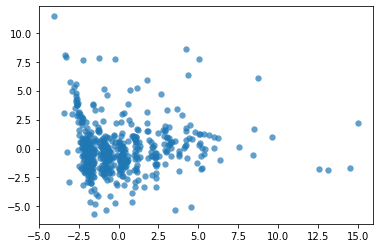

In [55]:
pca = PCA(n_components=2)
proj = pca.fit_transform(t1)
plt.scatter(*proj.T, **plot_kwds)
plt.show()

In [50]:
label

array([2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 0,
       1, 2, 3, 1, 2, 3, 2, 2, 0, 2, 2, 3, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 2, 2, 3, 2, 2, 3, 3, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 2, 1, 3, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2,
       0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 2, 2, 2, 2, 2, 0, 0, 3,
       2, 1, 1, 1, 1, 0, 0, 2, 3, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 0, 2, 2,
       0, 2, 3, 2, 0, 2, 2, 2, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 2, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 3,
       2, 0, 3, 1, 2, 0, 0, 3, 2, 0, 2, 0, 1, 1, 3, 2, 2, 2, 2, 2, 0, 2,
       0, 3, 2, 2, 2, 2, 2, 3, 1, 2, 2, 0, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 1, 3, 1, 2, 2, 1, 2, 2, 2,

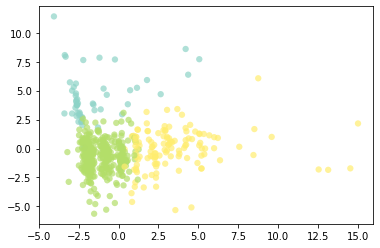

In [60]:
plt.scatter(*proj.T,c=label, **plot_kwds)
plt.show()

In [ ]:
##进一步探索与分析